In [1]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train

# train and test that consider only variable temperature 
%store -r train_t
%store -r test_t

# deseasonal series 
%store -r w_train_seas_diff

## PACAKES

In [2]:
import numpy as np
import pandas as pd
import statsmodels.datasets as smd
import sklearn
import scipy.stats as stats
from scipy import signal
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')


# Specific importing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#! pip install pmdarima
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

## ACF and PACF - Seasonal/Deseasonal 

Before apllying the automatic models we want to try to understand which models could be the best one, and the best parameters (p,d,q)(P,D,Q), observing the ACF and the PACF.

REMARK:

* MA(q): 
- ACF decrease fast to zero
- PACF slowly decrease to zero 

* AR(p)
- ACF decrease slowly to zero
- PACF decrease fast to zero 

* NON SEASONAL COMPONENT:
**BEFORE THE SEASONAL LAG**
* SEASONAL COMPONENT:
**AFTER THE SEASONAL LAG** and multiples

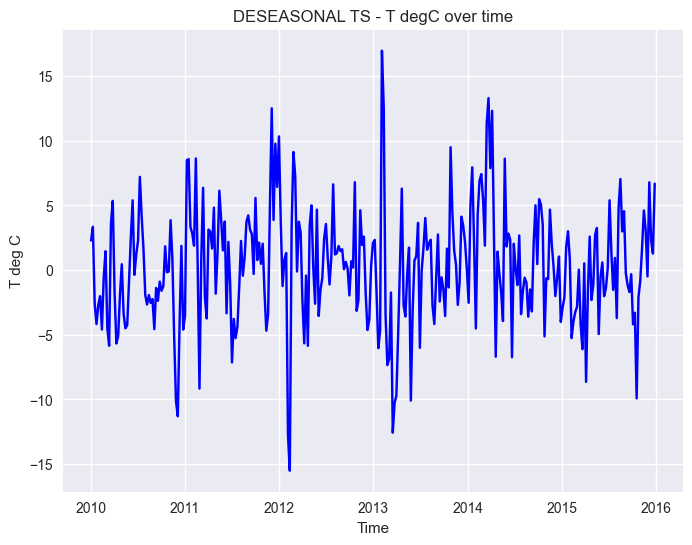

In [3]:
#ts 
plt.figure(figsize=(8,6))
plt.plot(w_train_seas_diff,color='Blue')
plt.xlabel('Time')
plt.ylabel('T deg C')
plt.title('DESEASONAL TS - T degC over time')
plt.show()

In [ ]:
# we have to remove null values
w_train_seas_diff.dropna(inplace=True)

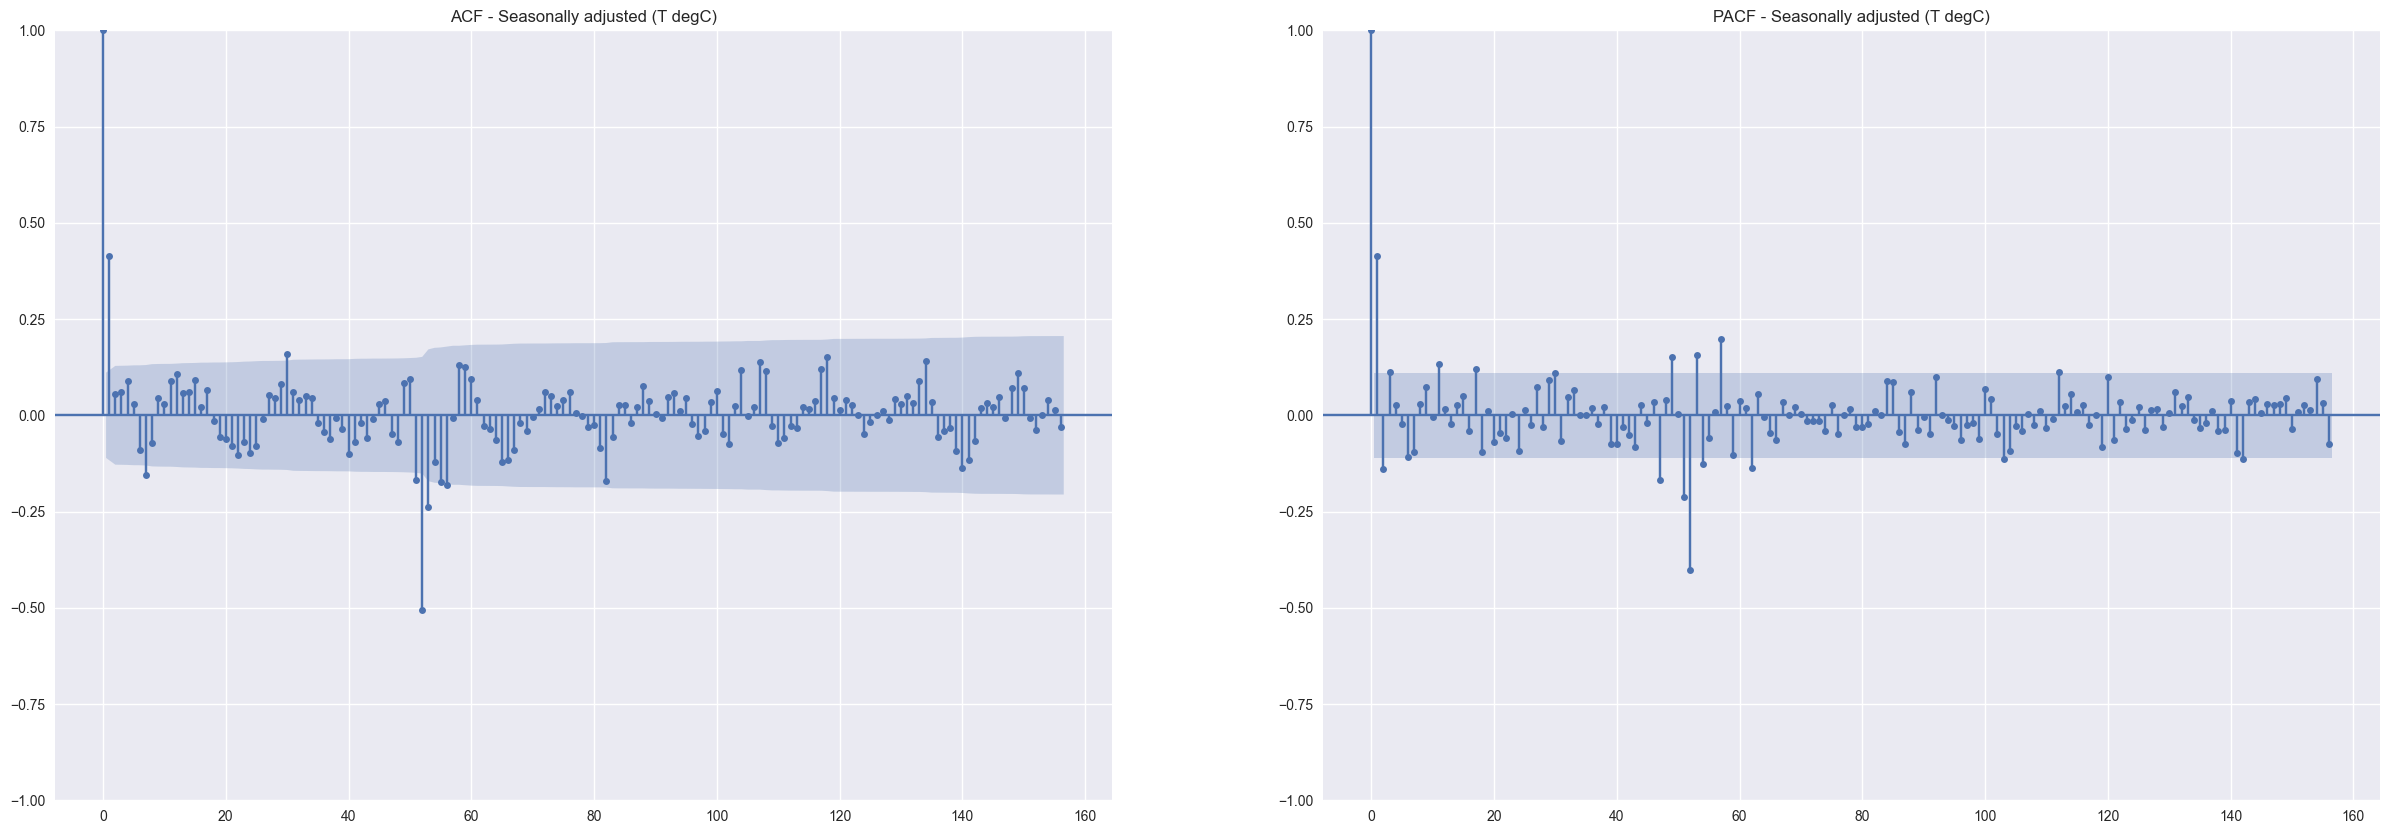

In [8]:
# ACF and PACF plot
fig, ax = plt.subplots(1, 2, figsize=(30,10))
plot_acf(w_train_seas_diff, lags=156, ax=ax[0], title='ACF - Seasonally adjusted (T degC)')
plot_pacf(w_train_seas_diff, lags=156, ax=ax[1], title='PACF - Seasonally adjusted (T degC)')
plt.show()

From the observation of this ACF and PACF, we can say:

* **NON SEASONAL PART - before the 52 lag:** Looking ACF: we have 3 significative peack, and the other lags decrease fast to zero; so we can individuate a MA(3) component. 
Looking PACF: the lags fast decrease to 0,  and we have 1 significant lag, so we can see a AR(1).

--> ITEGRATED PART = 0, since out series is stationary, we don't have to delite a long term component.

* **SEASONAL PART - after the 52 lag (with period 52):** Looking ACF: we have 1 significan component and again the other lags goes faster to zero.
Looking PACF: 2 significanl lags

--> INTEGRATED PART = 1, since we have to apply the seasonal differantiation 

So we can try to implement a model: Manual SARIMA(1,0,3)(1,1,2) m=52

## 1) Seasonal ARIMA

A seasonal ARIMA model (SARIMA) is made by including additional seasonal terms in the models we have seen so far.

These are generally written as ARIMA(p,d,q)(P,D,Q)m where the first part (p,d,q) refers to the non-seasonal component, while the second one (P,D,Q)m to the seasonal component. The term m refers to the seasonality (seasonal period, e.g., for annual data m = 12, quarterly data m = 4). This is also indicated as S (or s).

CF and PACF plots can help in identifying not only the non-seasonal component but also the seasonal part of an AR or MA model by looking at the seasonal lags of the PACF and ACF. For example:

* ARIMA(0,0,0)(0,0,1)12: 1) a significant spike at lag 12 in the ACF but no other significant spikes; 2) exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36);
* ARIMA(0,0,0)(1,0,0)12: 1) exponential decay in the seasonal lags of the ACF; 2) a single significant spike at lag 12 in the PACF.